# Deep Learning in Julia: Flux

We have now developed two networks (Autoencoders and CNNs) in a fairly standard format. Its rather clunky and involves a lot of boilerplate code with a lot of code recycling. This is (hopefully) helpful when we are beginning to develop networks as it allows us to inspect and modify the granular aspects and I would encourage you to go back and fiddle with different optimisers, training schedules, and the like. It also gives us space to absorb how the concepts relate to each other. However, much of this code is not particularly informative once we understand what it is doing. We don't really want to be thinking about networks in this fashion and the amount of boilerplate code actually begins to *detract* from an efficient workflow and bogs us down mentally. It is therefore an ideal target for packaging. We could create our own package from the previous code and might be a good exercise in Julia package development. Fortunately, some people have very kindly done this work for us and developed the `Flux.jl` package. 

Flux is a beautiful machine learning package that hits the sweet spot of being intiutive to use and easy to extend. It provides a nice abstraction of weights, biases, and layers allowing us to develop networks from the ground up (without having to worry about the implementation details). It also gives a implementation of common networks (CNNs, RNNs, LSTMs, etc.). We have actually already used the differentation routines which are given through `Zygote` and it can also be accelerated with GPUs through `CUDA`. It is therefore fast and accurate. The big advantage here is the *abstraction*. By taking away the implementation details but allowing us to customise when necessary we are free to think about the problem more abstractly; what our network is actually doing. This allows us to laser in where performance would most benefit: network structure, optimiser, hyper-parameters etc.

In [2]:
using Flux, Plots

## Models

A model, in its most basic form, is simply a transformation of data under some parameters. Consider a linear regression model $m(x) = Wx + b$: it takes a model input of dimension $n$ and transforms it into an output $m(x)$ by an $m \times n$ matrix of weights $W$ and an $m$ dimensional bias vector $b$. A more sophisticated model might pass this output through a non-linearity such as a ``sigmoid`` or ``relu`` function. This generic model is indeed the basis of each layer of a neural network. In Flux we start specifying models simply by typing them out:

In [3]:
W = rand(5,10)
b = rand(5)
relu(x) = (x .> 0) .* x
m(x) = relu(W * x + b)

m (generic function with 1 method)

Alternatively, we can use some inbuilt convenience functions. For example, the above layer would be considered dense in the literature, indicating an all-to-all set of connections between the neurons. This is the type of layer we used in our autoencoder, but not in our convolutional network. We can use the ``Dense`` and ``relu`` functions from Flux to encode this:

In [7]:
m2 = Dense(10=>5, relu)

Dense(10 => 5, relu)  # 55 parameters

Now we have a notion of how to construct a layer in Flux we might like to think how we could chain them together to create our network model. We could start by doing the most intuitive thing: composing functions.

In [12]:
m1 = Dense(20=>10, relu)
m2 = Dense(10=>30, σ)
M(x) = m2(m1(x))
display(M(rand(20)))

30-element Vector{Float64}:
 0.5896004574643633
 0.42489469601582636
 0.5184130014033625
 0.4384493357642541
 0.4882976483489414
 0.5530136203782829
 0.4604273890054617
 0.5532386886039592
 0.5100955192242892
 0.5027846749505339
 0.45052598945106986
 0.4777862321550047
 0.5003575678182459
 ⋮
 0.5081825254119815
 0.550419497969749
 0.4715744531836504
 0.4538745099468256
 0.5213337737853305
 0.5558359555316802
 0.6203137577163539
 0.5662471123871902
 0.5750200655437863
 0.5322374123773707
 0.4207583745838081
 0.5686589055219926

Flux also provides the useful convenience fucntion ``Chain`` which provides the same functionality and can be useful when tracking a model with hundreds or thousands of parameters.

In [13]:
M2 = Chain(Dense(20=>10, σ), Dense(10=>20, σ))
display(M2(rand(20)))

20-element Vector{Float64}:
 0.5350192667879335
 0.49117896522345084
 0.3697865427851019
 0.43909931706667404
 0.6652004085554711
 0.4366113277821498
 0.506672842318722
 0.46049294790222617
 0.4173549441648338
 0.6346379262125095
 0.5176893595314829
 0.49247586137963534
 0.5940976933445148
 0.49568266435901226
 0.5619501435977996
 0.4684308382522944
 0.5664013944425919
 0.42719880561297907
 0.5259088899616237
 0.4762805519495208

``Chain`` is really just a convenience wrapper for the recursive fold function ``foldr`` which starts with an input and recursively folds its arguments into each other. This works well to compose a vector of functions provided their inputs are composable and forms an important part of the functional programming paradigm introduced in Scientific Computing. It works well for us because we can now define our network, quite naturally, as a series of layers that a chained together. Some synatic sugar that might be helpful is to define the layers as a vector of models and splat them into a Chain:

``blockx = [xlayer1, xlayer2 ...]``

``blocky = [ylayer1, ylayer2 ...]``

``model = Chain(blockx...,blocky...)``

This is entirely unnecessary, but it can be useful to mentally chunk different aspects of the model construction process. The recommended practice is to go with the option that provides the best readability and least mental resistance.

## Parameters

Once we have defined the models we need to be able to keep track of the parameters. These are the absolutely critical components of training because in (almost) all models these are what vary in the training process, not the model structure itself. Aside: have a think about what it might mean for a machine learning model to vary its topological structure in addition to its parameterisation. For now, we will focus on the parameters. We use the ``Flux.params`` function in Flux to denote a set of trainable parameters. Returning to our single layer example:

In [47]:
W = rand(5,10)
b = rand(5)
m(x) = relu(W * x + b)
p = Flux.params(W, b)

Params([[0.3346877850368347 0.2081006317239017 … 0.2740459264976193 0.5120012210172121; 0.5830631942796966 0.03358296830146168 … 0.5496371888489937 0.3598547016895195; … ; 0.6366292261162219 0.08604897690748381 … 0.4312010334526313 0.0635273245913367; 0.3340646691153394 0.01088595090395339 … 0.5896703986321113 0.3341089793633001], [0.2830593337892672, 0.007583482941945108, 0.28863252316779586, 0.6567976239989174, 0.026620390432720464]])

Notice that ``Flux.params`` is not exported. This is an internal function that can integrate with automatic differentation routines. Its automatic for all ``Flux`` model layers such as ``Dense`` or ``Conv``. We will go through how to make this an automatic feature of our custom functions. It is sufficient in all cases to define parameters this way, if a little inconvenient. The `Flux.params` function also allows us to grab all the parameters of a model at once:

In [59]:
P = Flux.params(M2)

Params([Float32[-0.0761946 0.3496834 … -0.32314274 0.35231522; 0.31517833 -0.39835402 … -0.36932203 -0.30808625; … ; -0.09404021 0.3307577 … -0.080800965 -0.43716767; -0.048194382 0.09792921 … -0.1717542 -0.23017687], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.2629234 0.1782443 … -0.23503412 -0.38738242; -0.19924891 0.09440182 … -0.434062 -0.31518677; … ; -0.25074816 0.3757241 … -0.044414558 0.36858526; -0.31113312 0.3310343 … -0.34511277 -0.42833346], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

## Gradients

Taking gradients is the bedrock of a large portion of machine learning and of almost all of Deep Learning. Accordingly, ``Flux`` is essentially a convenience wrapper for taking and manipulating gradients in an arbitrarily flexible framework. The backbone of the automatic differentation routines is ``Zygote`` and we have already interacted with it in the previous notebooks. 

For our purposes we mainly want to interact with a differentiable loss function parameterised by a set of weights and biases. For a loss function `loss` (for this example MSE) we typically define the gradient in the following fashion:

In [48]:
x = rand(10); y = rand(5); # some dummy data
loss(x, y) = 1/length(y) * sum((m(x) .- y).^2) # loss

# gradient
g = gradient(()->loss(x,y), p)

Grads(...)

This is perhaps a little confusing at first glance. The gradient function typically takes a function as its first argument and the parameters it depends upon as subsequent parameters. In previous examples we painstakingly ensured that those arguments where visible as fields of the layer types, here it seems that has all vanished and the function is replaced with a zero argument call to loss on static objects. The gradient is being coordinated through the ``Flux.params`` call which tells the AD routine what it is allowed to differentiate and indeed if any of these parameters changes the ``loss`` function changes through ``m``. Therefore, we *can* differentiate this zero function call with respect to its parameters, and this is how we *naturally* think of this function to begin with: a function of data as arguments and a parameterisation. This gives the Flux framework a generically powerful base to work on allowing us to specify which parameters should change, and which should not. It is then very flexible. To find the gradients we simply call our gradient function on the parameters we are interested in.

In [49]:
g[W]

5×10 Matrix{Float64}:
 0.408023  0.393542  0.565883  0.708439  …  0.141586   0.539698  0.175377
 0.594892  0.573779  0.825051  1.03289      0.20643    0.786873  0.255698
 0.523555  0.504974  0.726114  0.909034     0.181676   0.692514  0.225035
 0.458213  0.441951  0.635492  0.795583     0.159002   0.606086  0.19695
 0.286102  0.275948  0.396793  0.496751     0.0992788  0.378432  0.122973

In [50]:
g[b]

5-element Vector{Float64}:
 0.7585801819735548
 1.1060003502789666
 0.9733734756497072
 0.8518922489154687
 0.5319101950046267

In [51]:
grads = [g[i] for i in p]

2-element Vector{Array{Float64}}:
 [0.4080229749648276 0.3935419418974479 … 0.5396980058894789 0.1753770330118069; 0.5948923580614941 0.5737791942516313 … 0.7868728945774548 0.2556975050907753; … ; 0.458213407114931 0.44195107899255015 … 0.6060856306267306 0.19694995810707713; 0.28610235982605114 0.2759483783409312 … 0.37843181034524914 0.12297293555171614]
 [0.7585801819735548, 1.1060003502789666, 0.9733734756497072, 0.8518922489154687, 0.5319101950046267]

With our dummy input data ``x`` we can construct predictors ``m(x)`` which can be made closer to the "true" data ``y`` bupdating our weights and biases by minimising our loss function. Let's see if we can improve our dummy prediction by training with a vanilla gradient descent routine.

In [114]:
for t = 1:3
    println("The loss at t = $(t) is $(loss(x,y))")
    W .= W .- 0.1 .* g[W]
    b .= b .- 0.1 .* g[b]
end

The loss at t = 1 is 0.0662062946698878
The loss at t = 2 is 0.0662062946698878
The loss at t = 3 is 0.0662062946698878


Hurrah! We have gotten better at predicting some random numbers.

## Training

Flux makes models incredibly easy to train in several key ways: large libraries of loss functions and optimisers, convient handling of data, and easy implementation of training loops and logging. The loss functions and optimisers can be found in the documentation [here](http://fluxml.ai/Flux.jl/stable/models/losses/) and [here](http://fluxml.ai/Flux.jl/stable/training/optimisers/) respectively. There is nothing to stop you writing your own. The typical loss function format is ``loss(x, y) = f(pred(x), y)`` where `pred(x)` is the model prediction. 

The optimiser functions typically have a sensible name (`Descent`, `Nesterov`, `Momentum`, `ADAM` etc.) and have fields $\eta$ and $\beta = (...)$ where $\eta$ is the learning rate and $\beta$ are the hyperparameters. These are all optional. Optimisers also have a generic optimiser type which behaves like `Chain` allowing us to chain optimisers together. This can be helpful for combining decay optimisers into some descent optimiser.

The model, loss, and optimiser can be used to update a models parameters with a call to the ``update!`` API. Note the bang (!) convention implies that something will be in-place mutated: the parameters, in this case. We can update individual parameters or loop through the entire set of the model parameters. Typically, we want to update all of the parameters at once, but in some cases we might want to restrict ourselves to a subset. We implement the update! 

In [116]:
# Feed some dummy data
x = rand(10); y=rand(7)

# Define the model environment and objective
model = Chain(Dense(10=>5, relu), Dense(5=>3, tanh), Dense(3=>7, σ))
p = Flux.params(model)
loss(x,y) = Flux.Losses.mse(model(x),y)
grad = gradient(() -> loss(x,y), p) 

# Choose the optimiser with default hyper-parameters or specify them
opt1 = Nesterov()
opt2 = ADAM(0.01, (0.8, 0.99))

# updating parameters all at once
Flux.update!(opt1, p, grad)

## updating parameters through each class
for u in p
    Flux.update!(opt2, p[u], grad[u])
end

LoadError: BoundsError: attempt to access 6-element Vector{Any} at index [Float32[0.63024837 0.403698 … 0.27613455 -0.14498141; -0.13892129 0.168675 … -0.002840189 0.38050225; … ; 0.09714002 0.1568826 … -0.12938896 -0.5016693; -0.3072016 -0.42563802 … -0.5861761 -0.5866567]]

This is good for a single datum but we normally deal with data with multiple entries. We could define a loss function which operates on all of the data simultaneously but Flux has already thought of this and provides another convenience API call: ``update!``. This function takes a loss function, model parameters, data points arranged as an iterable, and an optimiser and updates the parameters for each point in the data iterable. This is a full epoch of batch size one. Often data come in the form of vectors so the `zip` function can be very useful to create an iterable. Let's train our model for 20 epochs on a small dataset.

In [157]:
# data
datax = [ones(10) for i = 1:6]
datay = [zeros(7) for i = 1:6]
d = zip(datax, datay)

# train
for e in 1:20
    Flux.train!(loss, p, d, opt1)
end

A note about batching. The loss functions in Flux have an aggregation method which allows them to acculumate the individual differences between each element in the predictor and the datum and they refer to this as aggregating over the batch. Since the model output can be a vector we must be careful with our loss function and our batched loss function because if we incorporate simply the datum loss our batch size will always be 1.

In [ ]:
batch_loss(di) = mean([loss(x...) for x in di])

In [156]:
b = Flux.batch(d)
loss(b[2]...)
sum(model(b[1][1]).^2)/7

0.20283824576782483

## Regularisation

## Convenience Functions

## GPU

A large part of the modern success of Deep Learning has come from the sheer amount of compute we are able to dedicate to models making them incredibly large; parameters routinely run into the order billions. This has been facilitated by the GPU computing architectures. Flux has been designed so that most models can be easily transported to the GPU and back again using the `gpu` API call. This allows for very fast training and if you have the GPU resources I would encourage you to try it out and see and what model size GPU training becomes more effective.

In [61]:
mgpu = m |> gpu

m (generic function with 1 method)

It is always good practice to transfer models back to the CPU after training. This can ensure that weights and biases are saved correctly and in general is helpful conceptually when we want to use trained models in more generic implementations. To load a model back onto the CPU we use the `cpu` API call:

In [62]:
mcpu = m |> cpu

m (generic function with 1 method)

## Custom Layers

This, in some sense, is enough to compute *generic* models in Flux. It is clearly very intuitive to build neural networks with many layers in the generic Deep Learning sense. However, we should stress that *any* model can be constructed in this fashion. They can also be trained with the suite of optimisers and loss functions and if that is not enough we can design our own. All of the boring work has been done; we simply have to write out our models and interact with them as we would *naturally*. It is a very well designed and easy to use package and it lets us focus on the challenging aspect of model building, the model building, without needing to be bogged down with the implementation details which can be headache inducing and often not in a very fruitful sense.


Now that we have the basics of Flux under our belt we can demonstrate its flexibility. Let's try and code the autoencoder and convolutional networks that we painstakingly built from the ground up in the Flux framework. Hopefully, it will be a lot simpler ;).

## Example: Autoencoder in twenty

## Example: Convolution in ten

Let's reload our image data on blood cells with training labels.

In [2]:
using Images, FileIO, CSV, DataFrames, Flux, ProgressMeter, Random
datadirls = readdir("./data/sharks")
data_images = []
data_labels = []
for i in datadirls
    imgname = readdir("./data/sharks/" * i)
    for j in 1:20
        push!(data_images, imresize(load("./data/sharks/"*i*"/"*imgname[j]), (256,256)))
        push!(data_labels, i)
    end
end
shuffle = randperm(length(data_images))
data_images = data_images[shuffle]
data_labels = data_labels[shuffle]

function converter(im)
    tens = Array{Float64, 3}(undef, size(im)[1], size(im)[2], 3)
    for i in 1:size(im)[1]
        for j in 1:size(im)[2]
            tens[i, j, 1] = Float64(im[i,j].r)
            tens[i, j, 2] = Float64(im[i,j].g)
            tens[i, j, 3] = Float64(im[i,j].b)
        end
    end
    return tens
end

tsize = 100;
valsize = 20;
training_data = Float32.(cat([converter(data_images[i]) for i in 1:tsize]...,dims=4));
training_labels = Array{String,1}(data_labels[1:tsize]);
categ = unique(training_labels)
validation_data = Float32.(cat([converter(data_images[i]) for i in (tsize+1):(tsize + valsize)]...,dims=4));
validation_labels = data_labels[(tsize+1):(tsize + valsize)];

┌ Warning: Png warn: iCCP: known incorrect sRGB profile
└ @ PNGFiles /home/nicholas_gale/.julia/packages/PNGFiles/YCPWZ/src/wraphelpers.jl:2


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

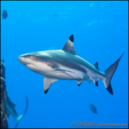
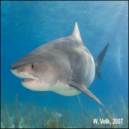
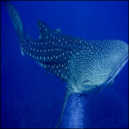
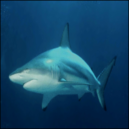
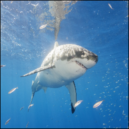
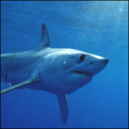
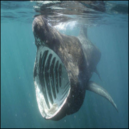
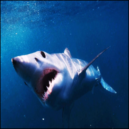
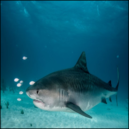
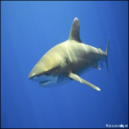
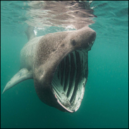
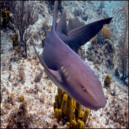
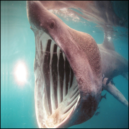
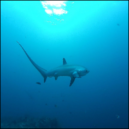
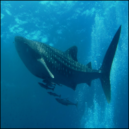
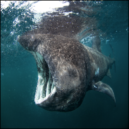
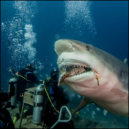
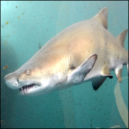
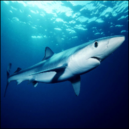
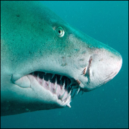
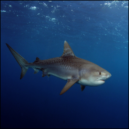
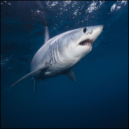
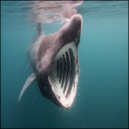
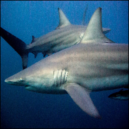
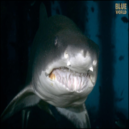
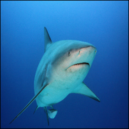
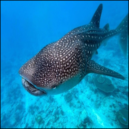
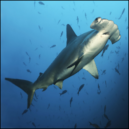
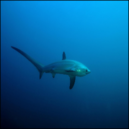
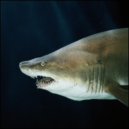
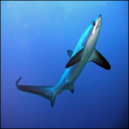
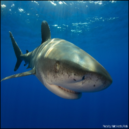
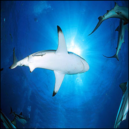
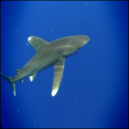
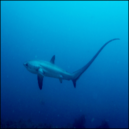
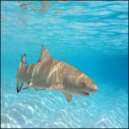
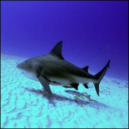
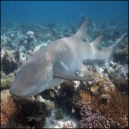
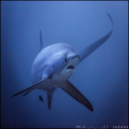
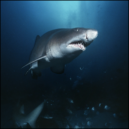
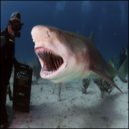
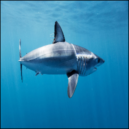
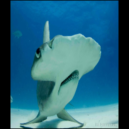
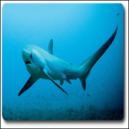
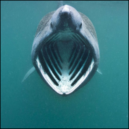
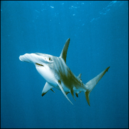
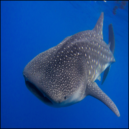
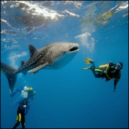
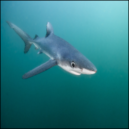
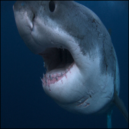
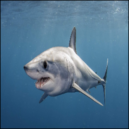
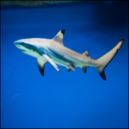
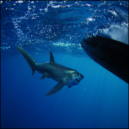
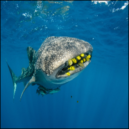
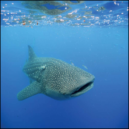
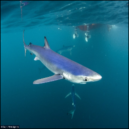
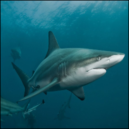
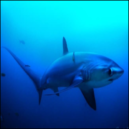
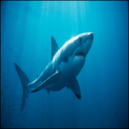
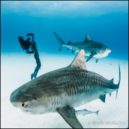
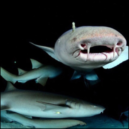
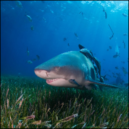
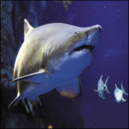
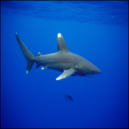
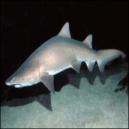
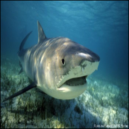
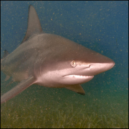
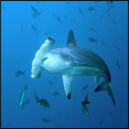
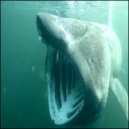
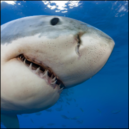
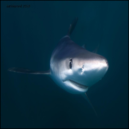
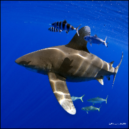
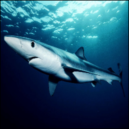
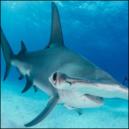
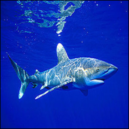
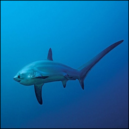
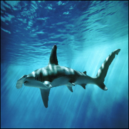
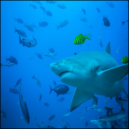
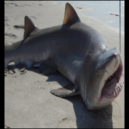
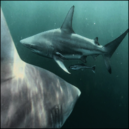
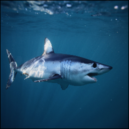
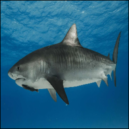
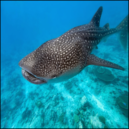
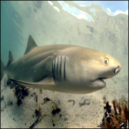
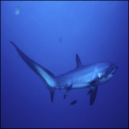
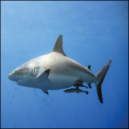
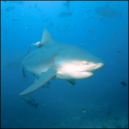
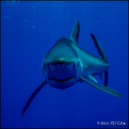
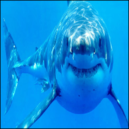
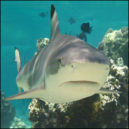
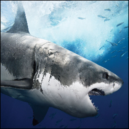
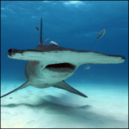
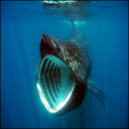
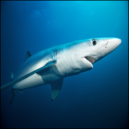
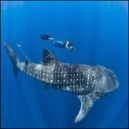
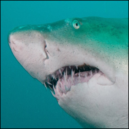
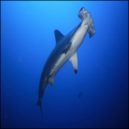
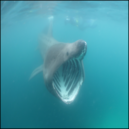
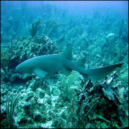
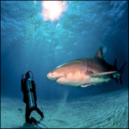
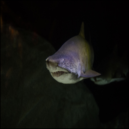
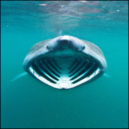
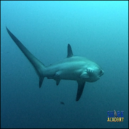
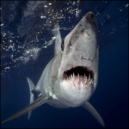
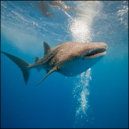
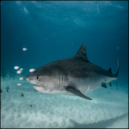
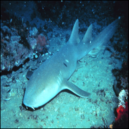
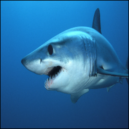
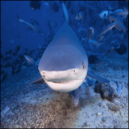
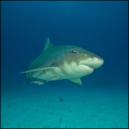
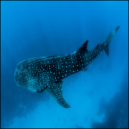
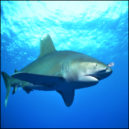
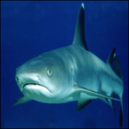
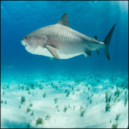
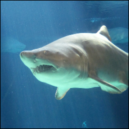
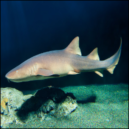
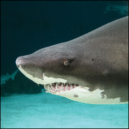
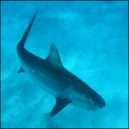
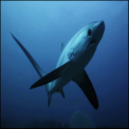
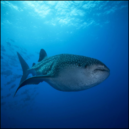

In [3]:
[data_images[1:120]...]

In [4]:
convolutional = Chain(Flux.Conv((3,3), 3=>14, relu), Flux.MaxPool((2,2)), Flux.Conv((5,5), 14 => 6, relu), Flux.MaxPool((2,2)), Flux.Conv((10,10), 6 => 2, relu), Flux.flatten, Dense(5408, length(categ), σ))
res = convolutional(validation_data[:,:,:,1:1])

14×1 Matrix{Float32}:
 0.45980456
 0.47119984
 0.49743664
 0.55052805
 0.51912624
 0.507349
 0.5517112
 0.5112452
 0.49576056
 0.5755977
 0.51279867
 0.5395207
 0.5096386
 0.43420866

In [68]:
convolutional = Chain(Flux.Conv((3,3), 3=>10, relu), Flux.MaxPool((2,2)), Flux.Conv((5,5), 10 => 5, relu), Flux.MaxPool((2,2)), Flux.Conv((10,10), 5 => 2, relu), Flux.flatten, Dense(5408, length(categ), σ))
p = Flux.params(convolutional)
opt = Momentum(0.1)
loss(fx, y) = Flux.logitcrossentropy(fx, y)

loss (generic function with 1 method)

In [1]:
epoch = 100
P = ProgressMeter.Progress(epoch)
for iterations in 1:epoch#round(Int, size(training_data)[end] * 100 / 5) # train for 100 epochs with batch size of 5
    i = 1:1 # rand(1:size(training_data)[end], 1)
    x, y = training_data[:,:,:,i], training_labels[i]
    g = Flux.gradient(() -> loss(convolutional(x), Flux.onehotbatch(y, categ)), p)
    Flux.Optimise.update!(opt, p, g)
    ProgressMeter.next!(P; showvalues = [(:loss, loss(convolutional(x), Flux.onehotbatch(y, categ)))])
end
pred = Flux.onecold(convolutional(validation_data[:,:,:,:]), categ)
println(sum(pred.==validation_labels)/length(pred))

predtest = Flux.onecold(convolutional(training_data[:,:,:,:]), categ)
println(sum(predtest.==training_labels)/length(predtest))

display(hcat(pred, validation_labels, pred .== validation_labels))
display(hcat(predtest, training_labels))
imgs = data_images[(tsize+1):(tsize + valsize)]
[imgs...]

LoadError: UndefVarError: ProgressMeter not defined

In [33]:
d=Dict("batched"=>validation_data, "labels"=>validation_labels, "imgs"=>data_images[(tsize+1):(tsize + valsize)])
using JLD2, BSON
JLD2.save("../Lectures/models/sharks/data.jld", d)
BSON.@save "../Lectures/models/sharks/conv.bson" convolutional

In [34]:
training_labels

20-element Vector{String}:
 "nurse"
 "whitetip"
 "blacktip"
 "sand tiger"
 "whale"
 "mako"
 "nurse"
 "nurse"
 "lemon"
 "whitetip"
 "lemon"
 "basking"
 "sand tiger"
 "hammerhead"
 "whitetip"
 "whale"
 "basking"
 "white"
 "bull"
 "thresher"